# Advanced Lane Finding
##  Camera Calibration


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
import math

Success: Calibrated camera.


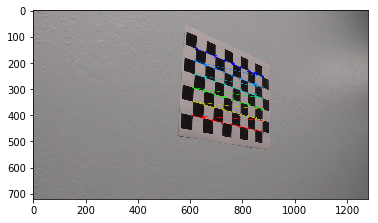

In [2]:
# prepare object points
nx = 9# Number of inside corners in x
ny = 6# Number of inside corners in y

# Make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")
# Create empty list of objPoints
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

for filename in images:

    img = cv2.imread(filename)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print('Success: Calibrated camera.')

##  Undistort an image

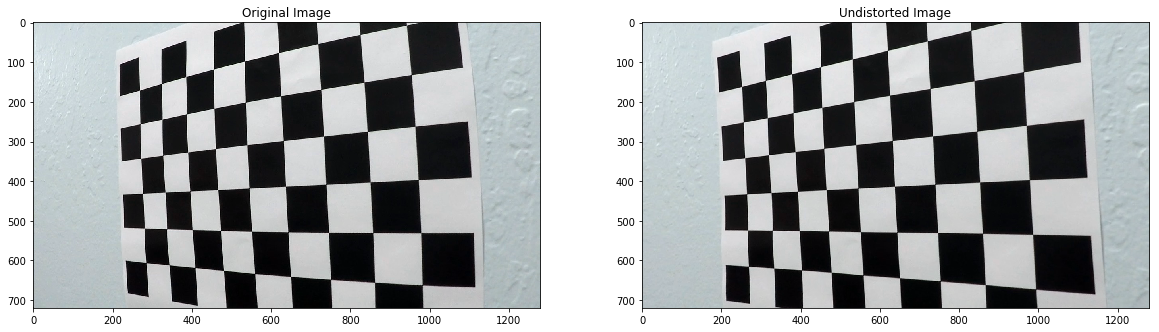

In [3]:

def undistort(img_, mtx_, dist_):
    return cv2.undistort(img_, mtx_, dist_, None, mtx_)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration4.jpg')
img_undistort = undistort(img,mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image')

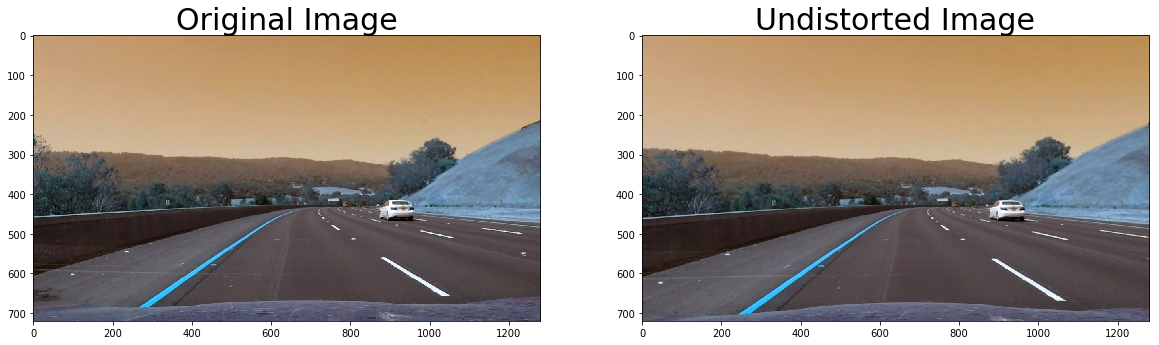

In [4]:
raw = cv2.imread("test_images/test3.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

## Create a thresholded binary image

In [5]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

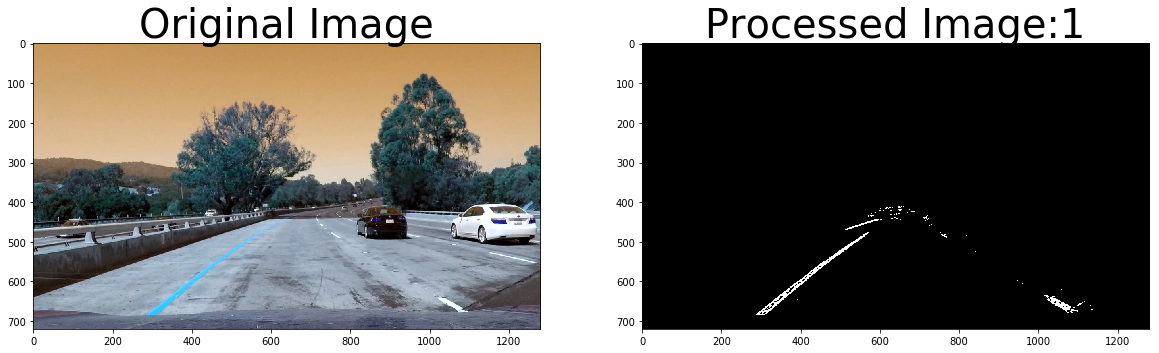

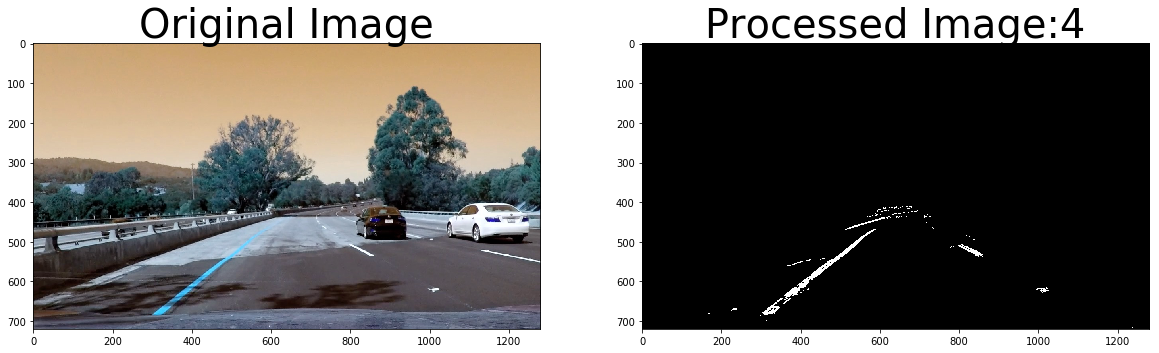

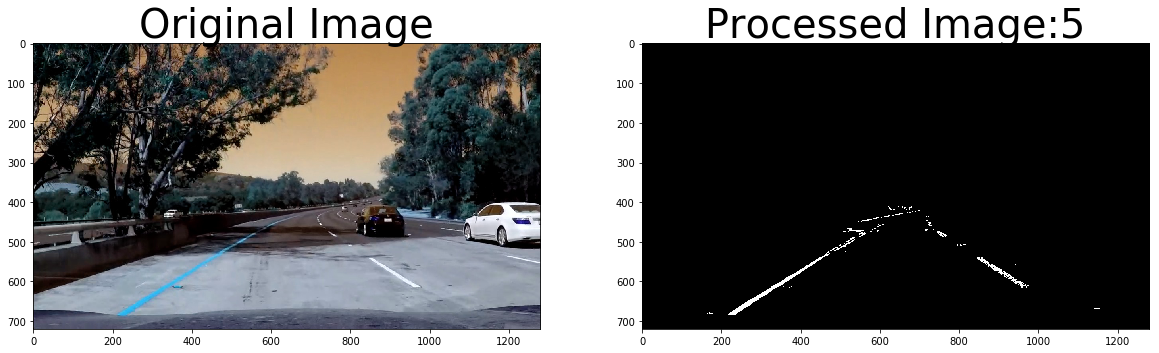

In [6]:

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# A pipeline for creating a thresholded binary image inside region of interest
combined_binary = 0
def binary_pipeline(img):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary

for i in range(1,7):
    raw = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(raw)
    binary = binary_pipeline(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    ax2.imshow(binary, cmap="gray")
    ax2.set_title('Processed Image:{}'.format(i), fontsize=40)

- img_size:  (1280, 720)
- src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
- dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])



## Unwrap image and generate bird eye view

image shape: (720, 1280, 3)
image size: (1280, 720)


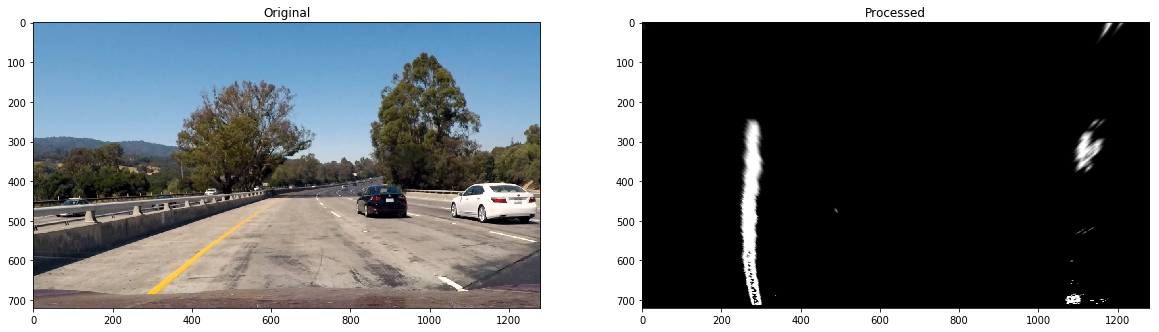

In [7]:
# Define image shape
image_shape = image.shape
img_size = (gray.shape[1], gray.shape[0])
print("image shape: {}".format(image_shape))
print("image size: {}".format(img_size))


area_of_interest = [[580,460],
                    [710,460],
                    [1150,720],
                    [150,720]]
src = np.float32(
    area_of_interest)

dst = np.float32(
        [[200,0],
         [1080,0],
         [1080,720],
         [200,720]])

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped_img = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped_img, M, Minv

# Example
example_image = mpimg.imread('test_images/test1.jpg')
binary_image = binary_pipeline(example_image)
warped,perspective_M, perspective_Minv = corners_unwarp(binary_image,nx, ny, mtx, dist)

# Plotting transformed image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Original')
ax1.imshow(example_image)


ax2.set_title('Processed')
ax2.imshow(warped, cmap="gray")



## Finding the lines

#### Here I used a Line class from Udacity's tips

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1
        

In [9]:
def find_nearest(array,value):
    # Function to find the nearest point from array
    if len(array) > 0:
        idx = (np.abs(array-value)).argmin()
        return array[idx]

def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2   

In [10]:
def sanity_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

# Sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    # If the direction is ok then pass
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .2:
        return right
    # If not then compute the value from the previous values
    else:
        return right_pre + (right_pre - right_pre2)

In [11]:
def find_lanes(n, image, x_window, lanes, \
               left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    
    index1 = np.zeros((n+1,2))
    index1[0] = [300, 1100]
    index1[1] = [300, 1100]
    # Set the first left and right values
    left, right = (300, 1100)
    # Set the center
    center = 700
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    for i in range(n-1):
        # set the window range.
        y_window_top = 720-720//n*(i+1)
        y_window_bottom = 720-720//n*i
        # If left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # Find the historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            # Set the direction
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            # Set the center
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > 600:
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
            # Append coordinates to the right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

### Finding Curvature

In [12]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

### Fit identified lane-line pixels  positions with a polynomial

In [13]:
def fit_lanes(image):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left = None
    right = None
    
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    # Find curvatures
    left_curverad  = find_curvature(yvals, left_fitx)
    right_curverad = find_curvature(yvals, right_fitx)
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad

/Users/hang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/Users/hang/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


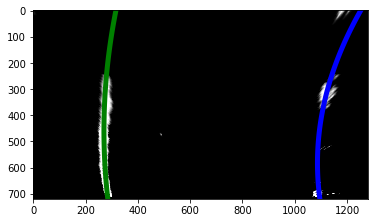

In [14]:
x_values = [area_of_interest[0][0],area_of_interest[1][0],area_of_interest[2][0],area_of_interest[3][0],area_of_interest[0][0]]
y_values = [area_of_interest[0][1],area_of_interest[1][1],area_of_interest[2][1],area_of_interest[3][1],area_of_interest[0][1]]

left_lane = Line()
right_lane = Line()
fname = 'test_images/test1.jpg'
img_raw = cv2.imread(fname)
img = binary_pipeline(img_raw)
warped, perspective_M, Minv = corners_unwarp(img, nx, ny, mtx, dist)
yvals, left_fitx, right_fitx, lx, ly, rx, ry, curvature = fit_lanes(warped)
plt.plot(left_fitx, yvals, color='green', linewidth=5)
plt.plot(right_fitx, yvals, color='blue', linewidth=5)
plt.imshow(warped, cmap="gray")

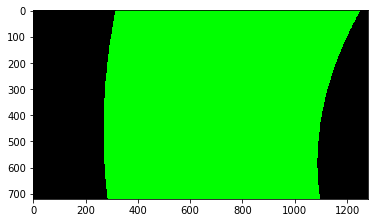

In [15]:

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
plt.imshow(cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0)), cmap="gray")

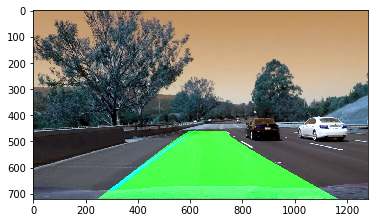

In [16]:
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
result = cv2.addWeighted(image, 1, newwarp, 0.8, 0)
plt.imshow(result, cmap="gray")

## Put them all together as a pipeline

In [17]:
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.8, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature = {} m".format(int(curvature))
    cv2.putText(result,text,(50,50), font, 2,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(50,100), font, 2,(255,255,255),2)
    return result

In [18]:
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = binary_pipeline(image)
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    # Find the lines fitting to left and right lanes
    a, b, c, lx, ly, rx, ry, curvature = fit_lanes(top_down)
    # Return the original image with colored region
    return draw_poly(image, top_down, a, b, c, lx, ly, rx, ry, perspective_Minv, curvature)

In [19]:
left_lane = Line()
right_lane = Line()    
# Use the information from fit_lane function to color the lanes
combined_img = process_image(img_raw)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ori_image = cv2.imread("test_images/test1.jpg")
ax1.set_title('Original', fontsize=30)
ax1.imshow(ori_image)


ax2.set_title('Processed', fontsize=30)
ax2.imshow(combined_img, cmap="gray")

/Users/hang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/Users/hang/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hang/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Generate video output

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def generate_video(input_filename_, output_filename_):
    clip1 = VideoFileClip(input_filename_)
    output_clip = clip1.fl_image(process_image) 
    %time output_clip.write_videofile(output_filename_, audio=False)


In [21]:
generate_video('project_video.mp4','project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:02<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 5s, sys: 1min 12s, total: 7min 17s
Wall time: 6min 3s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))